In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns

In [2]:
from datetime import datetime, date

In [3]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
# from IPython.display import SVG
# # # from graphviz import Source
# # from IPython.display import display
# from IPython.display import Image
import pydotplus

In [6]:
# from IPython.display import HTML
# style = "<style>svg{width:30% !important;height:30% !important;}</style>"
# HTML(style);

In [7]:
data_path = 'D:/GoogleDrive/Обмен/Programming/My projects/DataScience/Amgpgu/Magistracy/Data/'
# data_path = 'H:/GoogleDrive/Обмен/Programming/My projects/DataScience/Amgpgu/Magistracy/Data/'

In [8]:
bachelors_data_train = pd.read_excel(data_path + 'Data bachelors Train.xlsx')
bachelors_data_test = pd.read_excel(data_path + 'Data bachelors Test.xlsx')
pc_2015_data = pd.read_excel(data_path + 'Application PC 2015.xlsx')
pc_2016_data = pd.read_excel(data_path + 'Application PC 2016.xlsx')
pc_2017_data = pd.read_excel(data_path + 'Application PC 2017.xlsx')
pc_2018_data = pd.read_excel(data_path + 'Application PC 2018.xlsx')
pc_2019_data = pd.read_excel(data_path + 'Application PC 2019.xlsx')
pc_2020_data = pd.read_excel(data_path + 'Application PC 2020.xlsx')
pc_2021_data = pd.read_excel(data_path + 'Application PC 2021.xlsx')
pc_data_test = pd.read_excel(data_path + 'Application PC 2022.xlsx')

In [9]:
pc_data_train = pd.concat([pc_2015_data, pc_2016_data, pc_2017_data, pc_2018_data, pc_2019_data, pc_2020_data, pc_2021_data])

In [10]:
def pc_data_edit(df_pc_data):
    df_pc_data.drop_duplicates(inplace=True)
    df_pc_data['ПодалЗаявление'] = True    

In [11]:
pc_data_edit(pc_data_train)
pc_data_edit(pc_data_test)

In [12]:
# pc_data_train.head()

In [13]:
# bachelors_data_train.head()

In [14]:
display(pc_data_train.shape)
display(pc_data_train.Студент.nunique())

(669, 4)

632

In [15]:
pc_temp = pc_data_train.groupby(['Студент', 'ДатаРождения', 'ПодалЗаявление'], as_index=False)\
    .aggregate({'Год': 'count'})

In [16]:
pc_temp[pc_temp.Год > 1].shape

(32, 4)

In [17]:
bachelors_data_test.shape

(177, 9)

In [18]:
def students_data_edit(df_bachelors_data, df_pc_data):
    students_data = df_bachelors_data.merge(df_pc_data, on=['Студент', 'ДатаРождения', 'Год'], how='left').rename(columns=
                                                   {'Студент' : 'Student',
                                                    'Пол' : 'Sex',
                                                    'ДатаРождения' : 'BirthDate',
                                                    'Год' : 'YearOfEnding',
                                                    'ПедОбразование' : 'Pedagog',
                                                    'КурсовыеРаботы' : 'Coursework',
                                                    'Дисциплины' : 'Disciplines',
                                                    'ДипломныеРаботы' : 'Diploma',
                                                    'Практики' : 'Practices',
                                                    'ПодалЗаявление' : 'Applied'})
    students_data = students_data.fillna(False)
    students_data['DateOfEnding'] = students_data['YearOfEnding'] \
        .map(lambda x: date(int(x), 6, 20))
    students_data['Age'] = students_data['BirthDate'].map(lambda x: datetime.strptime(x, "%d.%m.%Y %H:%M:%S").date())
    students_data['Age'] = np.floor((students_data['DateOfEnding'] - students_data['Age']).dt.days / 365)
    students_data['Sex'] = np.where(students_data['Sex'] == 'Мужской', 'Male', 'Female')
    students_data['Pedagog'] = np.where(students_data['Pedagog'] == 1, True, False)
    #     X = students_data[['Sex', 'Age', 'Pedagog', 'Coursework', 'Disciplines', 'Diploma', 'Practices']]
    X = students_data[['Sex', 'Age', 'Pedagog', 'Disciplines']]
    X = pd.get_dummies(X, columns=['Sex', 'Pedagog'])
    y = students_data['Applied']
    return (X, y)

In [19]:
X_train, y_train = students_data_edit(bachelors_data_train, pc_data_train)
X_test, y_test = students_data_edit(bachelors_data_test, pc_data_test)

In [20]:
X_train.head()

,Age,Disciplines,Sex_Female,Sex_Male,Pedagog_False,Pedagog_True
0,24.0,4.586206,0,1,1,0
1,22.0,4.448275,1,0,1,0
2,25.0,4.580645,1,0,1,0
3,22.0,3.593750,1,0,1,0
4,21.0,3.939393,1,0,1,0


In [21]:
X_train.Age.count()

1371

In [22]:
X_train.Age.value_counts()

22.0    587
21.0    418
23.0    218
24.0     79
25.0     31
20.0     18
26.0     12
27.0      5
32.0      1
35.0      1
29.0      1
Name: Age, dtype: int64

In [23]:
gbrt_clf = GradientBoostingClassifier()
gbrt_parametrs = {'max_depth': range(1, 11),
             'learning_rate': [0.01, 0.1, 1],
             'n_estimators': range(50, 300, 50)
            }

In [24]:
grid_search_cv_clf = GridSearchCV(gbrt_clf, gbrt_parametrs, cv=5, scoring='roc_auc')

In [25]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': range(1, 11),
                         'n_estimators': range(50, 300, 50)},
             scoring='roc_auc')

In [26]:
display(grid_search_cv_clf.best_params_)
best_clf = grid_search_cv_clf.best_estimator_

{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 150}

In [27]:
y_pred = best_clf.predict(X_test)

In [28]:
display(best_clf.score(X_train, y_train))
display(best_clf.score(X_test, y_test))
display(metrics.precision_score(y_test, y_pred))
display(metrics.recall_score(y_test, y_pred))

0.8482859226841721

0.8926553672316384

C:\Users\sklyar\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

0.0

In [29]:
y_test.value_counts()

False    158
True      19
Name: Applied, dtype: int64

In [30]:
y_pred

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [31]:
best_clf.feature_importances_

array([0.10285785, 0.55640214, 0.        , 0.        , 0.17546564,
       0.16527437])

In [32]:
best_clf.feature_names_in_

array(['Age', 'Disciplines', 'Sex_Female', 'Sex_Male', 'Pedagog_False',
       'Pedagog_True'], dtype=object)

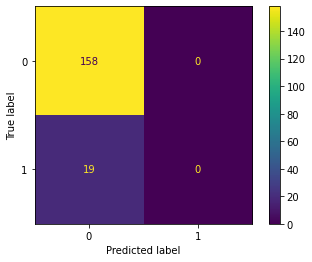

In [33]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

In [34]:
all_data = bachelors_data_train.merge(pc_data_train, on=['Студент', 'ДатаРождения', 'Год'], how='left').rename(columns=
                                                   {'Пол' : 'Sex',
                                                    'ДатаРождения' : 'BirthDate',
                                                    'Год' : 'YearOfEnding',
                                                    'ПедОбразование' : 'Pedagog',
                                                    'КурсовыеРаботы' : 'Coursework',
                                                    'Дисциплины' : 'Disciplines',
                                                    'ДипломныеРаботы' : 'Diploma',
                                                    'Практики' : 'Practices',
                                                    'ПодалЗаявление' : 'Applied'}).drop(['Студент'], axis=1)
all_data = all_data.fillna(False)

In [35]:
all_data['DateOfEnding'] = all_data['YearOfEnding'].map(lambda x: date(int(x), 6, 20))
all_data['Age'] = all_data['BirthDate'].map(lambda x: datetime.strptime(x, "%d.%m.%Y %H:%M:%S").date())
all_data['Age'] = np.floor((all_data['DateOfEnding'] - all_data['Age']).dt.days / 365)

In [36]:
all_data.head()

,Sex,BirthDate,YearOfEnding,Pedagog,Coursework,Disciplines,Diploma,Practices,Applied,DateOfEnding,Age
0,Мужской,29.10.1996 0:00:00,2021,0,5.000000,4.586206,5.0,5.000000,False,2021-06-20,24.0
1,Женский,12.03.1999 0:00:00,2021,0,4.666666,4.448275,4.0,4.000000,False,2021-06-20,22.0
2,Женский,30.04.1995 0:00:00,2020,0,5.000000,4.580645,5.0,5.000000,False,2020-06-20,25.0
3,Женский,06.06.1995 0:00:00,2017,0,3.000000,3.593750,4.0,3.666666,False,2017-06-20,22.0
4,Женский,10.08.1995 0:00:00,2017,0,4.333333,3.939393,5.0,4.333333,False,2017-06-20,21.0


In [37]:
all_data[all_data.Applied == True].Age.value_counts()

22.0    92
21.0    69
23.0    29
24.0     8
25.0     3
26.0     3
20.0     2
27.0     1
35.0     1
Name: Age, dtype: int64

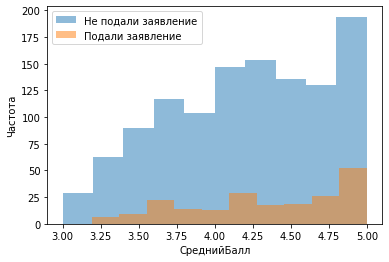

In [38]:
Applied = all_data[all_data.Applied == True]['Disciplines']
NotApplied = all_data[all_data.Applied == False]['Disciplines']
plt.hist(NotApplied, alpha=.5)
plt.hist(Applied, alpha=.5)
plt.xlabel('СреднийБалл')
plt.ylabel('Частота')
plt.legend(['Не подали заявление', 'Подали заявление'], loc='best');

In [39]:
Applied.sort_values(ascending=True)

972     3.193548
216     3.200000
791     3.214285
872     3.285714
1066    3.291666
          ...   
92      5.000000
888     5.000000
197     5.000000
508     5.000000
1105    5.000000
Name: Disciplines, Length: 208, dtype: float64

In [40]:
# best_clf.predict_proba(X_test)

In [41]:
y_pred_lower_threshold = best_clf.predict_proba(X_test)[:, 1] > 0.25

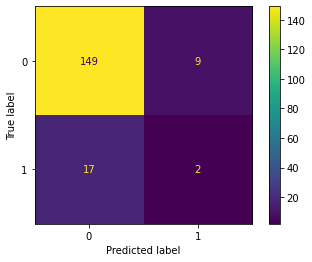

In [42]:
conf_matrix = confusion_matrix(y_test, y_pred_lower_threshold)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

In [43]:
display(metrics.precision_score(y_test, y_pred_lower_threshold))
display(metrics.recall_score(y_test, y_pred_lower_threshold))

0.18181818181818182

0.10526315789473684

In [44]:
tree_clf = DecisionTreeClassifier()
tree_parametrs = {'criterion': ['gini', 'entropy'],
             'max_depth': [5, 10, 15, 20],
             'min_samples_split': range(2, 11),
             'min_samples_leaf': range(1, 6)
            }

In [45]:
grid_search_cv_tree = GridSearchCV(tree_clf, tree_parametrs, cv=5, scoring='roc_auc')

In [46]:
grid_search_cv_tree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': range(1, 6),
                         'min_samples_split': range(2, 11)},
             scoring='roc_auc')

In [47]:
display(grid_search_cv_tree.best_params_)
best_tree_clf = grid_search_cv_tree.best_estimator_

{'criterion': 'gini',
 'max_depth': 15,
 'min_samples_leaf': 4,
 'min_samples_split': 2}

In [48]:
y_pred_tree = best_tree_clf.predict(X_test)

In [49]:
display(best_tree_clf.score(X_train, y_train))
display(best_tree_clf.score(X_test, y_test))
display(metrics.precision_score(y_test, y_pred_tree))
display(metrics.recall_score(y_test, y_pred_tree))

0.8694383661560905

0.8248587570621468

0.0

0.0

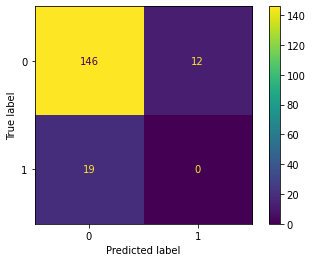

In [50]:
conf_matrix = confusion_matrix(y_test, y_pred_tree)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

In [51]:
dot_data = tree.export_graphviz(best_tree_clf, out_file=None
       , feature_names=list(X_train), class_names=['NotApplied', 'Applied']
       , filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree.png');